In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error # as cost function, to be used in RMSE
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz  
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from datetime import datetime
import time
seed = 0 # initialize consistent random_state

In [2]:
import pydotplus
from IPython.display import Image
# graph = pydotplus.graph_from_dot_data(dot_data)
# Image(graph.create_png())

In [3]:
raw_df = pd.read_csv('cleaned_wonder_plus_2021.csv')
holdout_2021 = raw_df[raw_df['Year'] == 2021].copy()
cleaned = raw_df[raw_df['Year'] < 2021].copy()
cleaned['Year'].value_counts()
# cleaned

Year
2020    1682
2017    1597
2016    1572
2019    1563
2018    1558
2015    1480
2014    1420
2013    1392
2012    1360
2011    1341
2009    1305
2010    1298
2008    1259
2007    1237
2006    1218
2005    1174
2004    1089
2003    1069
2002     982
2001     919
1999     873
2000     854
Name: count, dtype: int64

In [4]:
fentanyl = cleaned[cleaned['Multiple Cause of death'] == 'Other synthetic narcotics'].copy()
fentanyl

,Multiple Cause of death,Multiple Cause of death Code,Year,Year Code,Gender,Gender Code,Race,Race Code,Five-Year Age Groups,Five-Year Age Groups Code,Deaths,Population,Crude Rate,socioec quintile,age_midpoint
3548,Other synthetic narcotics,T40.4,1999,1999,Female,F,American Indian or Alaska Native,1002-5,25-29 years,25-29,5,35278,14.173139,1.0,27.0
3549,Other synthetic narcotics,T40.4,1999,1999,Female,F,American Indian or Alaska Native,1002-5,40-44 years,40-44,5,38192,13.091747,1.0,42.0
3550,Other synthetic narcotics,T40.4,1999,1999,Female,F,Asian or Pacific Islander,A-PI,40-44 years,40-44,5,28791,17.366538,1.0,42.0
3551,Other synthetic narcotics,T40.4,1999,1999,Female,F,Asian or Pacific Islander,A-PI,45-49 years,45-49,5,26161,19.112419,1.0,47.0
3552,Other synthetic narcotics,T40.4,1999,1999,Female,F,Black or African American,2054-5,20-24 years,20-24,5,369758,1.352236,1.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27138,Other synthetic narcotics,T40.4,2020,2020,Male,M,White,2106-3,60-64 years,60-64,281,1637972,17.155360,5.0,62.0
27139,Other synthetic narcotics,T40.4,2020,2020,Male,M,White,2106-3,65-69 years,65-69,112,1328961,8.427636,5.0,67.0
27140,Other synthetic narcotics,T40.4,2020,2020,Male,M,White,2106-3,70-74 years,70-74,22,1068045,2.059838,5.0,72.0
27141,Other synthetic narcotics,T40.4,2020,2020,Male,M,White,2106-3,75-79 years,75-79,5,702229,0.712018,5.0,77.0


# Manage Outliers
Do we want to ignore outliers? They are some of the few data points where we have actual data and are not using our artificial "suppressed" average of 5 deaths. 

We can do this per socioeconomic quintile or any of the other features, but I do so for the entire dataset

For now, I identify using the IQR and consider anything outside the 1.5 * upper or lower bounds as an outlier. We can also do 3 standard deviations away

In [5]:
# identify interquartile range as the bounds
fentanyl_outliers_working = fentanyl.copy()

# set opiod index to column to reset index
fentanyl_outliers_working['narcotics_index'] = fentanyl_outliers_working.index
fentanyl_outliers_working = fentanyl_outliers_working.reset_index(drop = True) #reset_index creates redundant index col

# calculate upper and lower bounds
print(f'Original data shape: {fentanyl.shape[0]}')
Q1 = fentanyl_outliers_working['Crude Rate'].quantile(0.25)
Q3 = fentanyl_outliers_working['Crude Rate'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - (1.5 * IQR)
upper = Q3 + (1.5 * IQR)
 
# indices of outlier rows
outliers_beyond_upper = np.where(fentanyl_outliers_working['Crude Rate'] >= upper)[0]
outliers_beyond_lower = np.where(fentanyl_outliers_working['Crude Rate'] <= lower)[0]
# print(outliers_beyond_lower)
# print(outliers_beyond_upper)
outliers_arr = np.append(outliers_beyond_upper , outliers_beyond_lower)
print(f'Number of outliers: {len(outliers_arr)}')
# fentanyl_working
fentanyl_outliers_removed = fentanyl_outliers_working.drop(index = outliers_arr)
fentanyl_outliers_removed

Original data shape: 5578
Number of outliers: 360


,Multiple Cause of death,Multiple Cause of death Code,Year,Year Code,Gender,Gender Code,Race,Race Code,Five-Year Age Groups,Five-Year Age Groups Code,Deaths,Population,Crude Rate,socioec quintile,age_midpoint,narcotics_index
0,Other synthetic narcotics,T40.4,1999,1999,Female,F,American Indian or Alaska Native,1002-5,25-29 years,25-29,5,35278,14.173139,1.0,27.0,3548
1,Other synthetic narcotics,T40.4,1999,1999,Female,F,American Indian or Alaska Native,1002-5,40-44 years,40-44,5,38192,13.091747,1.0,42.0,3549
2,Other synthetic narcotics,T40.4,1999,1999,Female,F,Asian or Pacific Islander,A-PI,40-44 years,40-44,5,28791,17.366538,1.0,42.0,3550
3,Other synthetic narcotics,T40.4,1999,1999,Female,F,Asian or Pacific Islander,A-PI,45-49 years,45-49,5,26161,19.112419,1.0,47.0,3551
4,Other synthetic narcotics,T40.4,1999,1999,Female,F,Black or African American,2054-5,20-24 years,20-24,5,369758,1.352236,1.0,22.0,3552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5573,Other synthetic narcotics,T40.4,2020,2020,Male,M,White,2106-3,60-64 years,60-64,281,1637972,17.155360,5.0,62.0,27138
5574,Other synthetic narcotics,T40.4,2020,2020,Male,M,White,2106-3,65-69 years,65-69,112,1328961,8.427636,5.0,67.0,27139
5575,Other synthetic narcotics,T40.4,2020,2020,Male,M,White,2106-3,70-74 years,70-74,22,1068045,2.059838,5.0,72.0,27140
5576,Other synthetic narcotics,T40.4,2020,2020,Male,M,White,2106-3,75-79 years,75-79,5,702229,0.712018,5.0,77.0,27141


# Decide dataset to use
Can use either fentanyl_outliers_removed or original fentanyl, but set fentanyl_bronze as starting "dataset to be used throughout"

For now, predict only crude rate (y), but we can do all the same below by switching to life years lost

In [6]:
# features and labels
x_cols = ['Year', 'Gender', 'Race', 'Five-Year Age Groups', 'Population', 'socioec quintile']
y_col = ['Crude Rate']

# select dataset to use
fentanyl_bronze = fentanyl.loc[:, np.append(x_cols, y_col)].copy() #or #fentanyl_outliers_removed.copy()
# fentanyl_bronze.reset_index(inplace = True, drop = True).drop()
fentanyl_bronze

,Year,Gender,Race,Five-Year Age Groups,Population,socioec quintile,Crude Rate
3548,1999,Female,American Indian or Alaska Native,25-29 years,35278,1.0,14.173139
3549,1999,Female,American Indian or Alaska Native,40-44 years,38192,1.0,13.091747
3550,1999,Female,Asian or Pacific Islander,40-44 years,28791,1.0,17.366538
3551,1999,Female,Asian or Pacific Islander,45-49 years,26161,1.0,19.112419
3552,1999,Female,Black or African American,20-24 years,369758,1.0,1.352236
...,...,...,...,...,...,...,...
27138,2020,Male,White,60-64 years,1637972,5.0,17.155360
27139,2020,Male,White,65-69 years,1328961,5.0,8.427636
27140,2020,Male,White,70-74 years,1068045,5.0,2.059838
27141,2020,Male,White,75-79 years,702229,5.0,0.712018


In [7]:
fentanyl_silver = pd.get_dummies(fentanyl_bronze)
fentanyl_silver

,Year,Population,socioec quintile,Crude Rate,Gender_Female,Gender_Male,Race_American Indian or Alaska Native,Race_Asian or Pacific Islander,Race_Black or African American,Race_White,...,Five-Year Age Groups_45-49 years,Five-Year Age Groups_5-9 years,Five-Year Age Groups_50-54 years,Five-Year Age Groups_55-59 years,Five-Year Age Groups_60-64 years,Five-Year Age Groups_65-69 years,Five-Year Age Groups_70-74 years,Five-Year Age Groups_75-79 years,Five-Year Age Groups_80-84 years,Five-Year Age Groups_< 1 year
3548,1999,35278,1.0,14.173139,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3549,1999,38192,1.0,13.091747,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3550,1999,28791,1.0,17.366538,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3551,1999,26161,1.0,19.112419,True,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False
3552,1999,369758,1.0,1.352236,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27138,2020,1637972,5.0,17.155360,False,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
27139,2020,1328961,5.0,8.427636,False,True,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
27140,2020,1068045,5.0,2.059838,False,True,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
27141,2020,702229,5.0,0.712018,False,True,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False


# Split data into test/train

In [8]:
x = fentanyl_silver.drop(y_col, axis = 1) # get only features
y = fentanyl_silver.loc[:, y_col]

x
# y

,Year,Population,socioec quintile,Gender_Female,Gender_Male,Race_American Indian or Alaska Native,Race_Asian or Pacific Islander,Race_Black or African American,Race_White,Five-Year Age Groups_1-4 years,...,Five-Year Age Groups_45-49 years,Five-Year Age Groups_5-9 years,Five-Year Age Groups_50-54 years,Five-Year Age Groups_55-59 years,Five-Year Age Groups_60-64 years,Five-Year Age Groups_65-69 years,Five-Year Age Groups_70-74 years,Five-Year Age Groups_75-79 years,Five-Year Age Groups_80-84 years,Five-Year Age Groups_< 1 year
3548,1999,35278,1.0,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3549,1999,38192,1.0,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3550,1999,28791,1.0,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3551,1999,26161,1.0,True,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3552,1999,369758,1.0,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27138,2020,1637972,5.0,False,True,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
27139,2020,1328961,5.0,False,True,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
27140,2020,1068045,5.0,False,True,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
27141,2020,702229,5.0,False,True,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False


In [9]:
# train/test set at 80/20 split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 28)
print(f'Training Features Shape: {x_train.shape}')
print(f'Training Labels Shape:  {x_test.shape}')
print(f'Testing Features Shape: {y_train.shape}')
print(f'Testing Labels Shape: {y_test.shape}')

Training Features Shape: (4462, 27)
Training Labels Shape:  (1116, 27)
Testing Features Shape: (4462, 1)
Testing Labels Shape: (1116, 1)


In [10]:
test_df = x_test.merge(y_test, left_index = True, right_index = True) #merge on index 
test_df

,Year,Population,socioec quintile,Gender_Female,Gender_Male,Race_American Indian or Alaska Native,Race_Asian or Pacific Islander,Race_Black or African American,Race_White,Five-Year Age Groups_1-4 years,...,Five-Year Age Groups_5-9 years,Five-Year Age Groups_50-54 years,Five-Year Age Groups_55-59 years,Five-Year Age Groups_60-64 years,Five-Year Age Groups_65-69 years,Five-Year Age Groups_70-74 years,Five-Year Age Groups_75-79 years,Five-Year Age Groups_80-84 years,Five-Year Age Groups_< 1 year,Crude Rate
20430,2000,1789402,4.0,False,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,0.279423
21036,2015,220496,4.0,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,2.267615
15700,2020,22306,3.0,True,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,22.415494
3883,2007,1721590,1.0,False,True,False,False,False,True,False,...,False,True,False,False,False,False,False,False,False,1.800661
9826,2016,34937,2.0,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,14.311475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20449,2001,984600,4.0,True,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,0.507820
26775,2016,121729,5.0,False,True,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,17.251436
15288,2014,370313,3.0,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,1.350209
9968,2017,1113358,2.0,False,True,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,0.449092


# Compare against using simple average
Compare any models against the error calculated from the simple average crude rate for the quintile

In [11]:
test_averages = test_df.groupby('socioec quintile', as_index = False).agg(quintile_ave = ('Crude Rate', 'mean'))
test_averages

,socioec quintile,quintile_ave
0,1.0,6.747311
1,2.0,7.823423
2,3.0,7.928443
3,4.0,6.335294
4,5.0,7.190898


In [12]:
test_df_ave_preds = test_df.merge(test_averages, on = 'socioec quintile')
print(f'Test df shape: {test_df_ave_preds.shape[0]}')

Test df shape: 1116


Finding the root mean square error involves calculating the residual for each observation (y – ŷ) and squaring it. Then sum all the squared residuals. Divide that sum by the error degrees of freedom in your model (N – P) to find the average squared residual, more technically known as the mean squared error (MSE). Finally, take the square root to find the RSME.

In [13]:
# calculate root mean squared error: 
test_df_ave_preds['residual'] = (test_df_ave_preds['quintile_ave'] - test_df_ave_preds['Crude Rate'])**2

rmse = round(np.sqrt(np.mean(test_df_ave_preds['residual'])), 2)
print(f'Root mean squared error error: {rmse}')
test_df_ave_preds
# Average baseline error:  5.06 degrees.

Root mean squared error error: 10.29


,Year,Population,socioec quintile,Gender_Female,Gender_Male,Race_American Indian or Alaska Native,Race_Asian or Pacific Islander,Race_Black or African American,Race_White,Five-Year Age Groups_1-4 years,...,Five-Year Age Groups_55-59 years,Five-Year Age Groups_60-64 years,Five-Year Age Groups_65-69 years,Five-Year Age Groups_70-74 years,Five-Year Age Groups_75-79 years,Five-Year Age Groups_80-84 years,Five-Year Age Groups_< 1 year,Crude Rate,quintile_ave,residual
0,2000,1789402,4.0,False,True,False,False,False,True,False,...,False,False,False,False,False,False,False,0.279423,6.335294,36.673573
1,2015,220496,4.0,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,2.267615,6.335294,16.546013
2,2020,36108,4.0,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,13.847347,6.335294,56.430939
3,2013,178226,4.0,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,2.805427,6.335294,12.459962
4,2001,751510,4.0,False,True,False,False,False,True,False,...,False,False,True,False,False,False,False,0.665327,6.335294,32.148523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,2005,193642,5.0,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,2.582084,7.190898,21.241163
1112,2014,1545101,5.0,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,0.323603,7.190898,47.159736
1113,1999,240065,5.0,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,2.082769,7.190898,26.092981
1114,2016,121729,5.0,False,True,False,False,True,False,False,...,False,False,True,False,False,False,False,17.251436,7.190898,101.214422


##### Example Decision Tree (DT) Visualization 
The actual dts are too big, so shortening data to include as an example

In [14]:
# x_train.iloc[:,[0:5]]

In [15]:
# # attempt to visualize example DT
# dec_tree_example = DecisionTreeRegressor(random_state = seed)

# # Fitting the Decision Tree Regression model to the data
# dec_tree_example.fit(x_train[0:5,:], y_train)

# # export the decision tree model to a tree_structure.dot file 
# # paste the contents of the file to webgraphviz.com
# dot_data = export_graphviz(dec_tree_example, out_file = None, 
#                feature_names =x_train.columns, filled = True) #out_file ='tree_structure.dot'
# graph = pydotplus.graphviz.graph_from_dot_data(dot_data)
# Image(graph.create_png())

# Single Decision Tree

In [16]:
dec_tree_reg = DecisionTreeRegressor(random_state = seed)

# Fitting the Decision Tree Regression model to the data
dec_tree_reg.fit(x_train, y_train)
dec_tree_name = "Base Decision Tree"

In [17]:
# Predicting the target values of the test set
y_pred = dec_tree_reg.predict(x_test)
y_pred
y_test
# RMSE (Root Mean Square Error)
# rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))

mse = np.square(np.subtract(y_test['Crude Rate'], y_pred)).mean()
rmse = math.sqrt(mse)
# rmse = round(np.sqrt((np.mean(y_test['Crude Rate'] - y_pred) ** 2)/2), 2)
rmse_oob = round(mean_squared_error(y_test['Crude Rate'], y_pred, squared = False), 2) #testing out-of-box caclulation of mse. squared=False: return RMSE
print("RMSE: ", rmse)
print("RMSE OOB: ", rmse_oob)
y_test

RMSE:  4.074309373729859
RMSE OOB:  4.07


,Crude Rate
20430,0.279423
21036,2.267615
15700,22.415494
3883,1.800661
9826,14.311475
...,...
20449,0.507820
26775,17.251436
15288,1.350209
9968,0.449092


In [18]:
test_joined = x_test.join(y_test).rename(columns = {'Crude Rate': 'Actual Crude Rate'})
test_joined['Predicted Crude Rate'] = y_pred #
test_joined

,Year,Population,socioec quintile,Gender_Female,Gender_Male,Race_American Indian or Alaska Native,Race_Asian or Pacific Islander,Race_Black or African American,Race_White,Five-Year Age Groups_1-4 years,...,Five-Year Age Groups_50-54 years,Five-Year Age Groups_55-59 years,Five-Year Age Groups_60-64 years,Five-Year Age Groups_65-69 years,Five-Year Age Groups_70-74 years,Five-Year Age Groups_75-79 years,Five-Year Age Groups_80-84 years,Five-Year Age Groups_< 1 year,Actual Crude Rate,Predicted Crude Rate
20430,2000,1789402,4.0,False,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,0.279423,0.279542
21036,2015,220496,4.0,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,2.267615,2.327086
15700,2020,22306,3.0,True,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,22.415494,22.469890
3883,2007,1721590,1.0,False,True,False,False,False,True,False,...,True,False,False,False,False,False,False,False,1.800661,2.257086
9826,2016,34937,2.0,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,14.311475,80.091533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20449,2001,984600,4.0,True,False,False,False,False,True,False,...,False,False,True,False,False,False,False,False,0.507820,0.506761
26775,2016,121729,5.0,False,True,False,False,True,False,False,...,False,False,False,True,False,False,False,False,17.251436,1.908659
15288,2014,370313,3.0,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,1.350209,1.349546
9968,2017,1113358,2.0,False,True,False,False,False,True,False,...,False,False,False,False,True,False,False,False,0.449092,0.473890


In [19]:
y_pred

array([ 0.27954215,  2.32708588, 22.46989035, ...,  1.34954588,
        0.47389008,  3.597936  ])

In [20]:
##### test time for permutation_importance
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

### horizontal bar chart of feature importances using mean decrease in impurity - may not be ideal
def rate_features_impurity(x, trained_model):
    features = x.columns
    f_i = list(zip(features,trained_model.feature_importances_))
    f_i.sort(key = lambda x : x[1])
    plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
    plt.show()

def rate_features_permutation(trained_model, x_train, x_test, y_pred, model_name = "base model name"):
    feature_names = x_train.columns

    start_time = time.time()
    # permutation_importance is better than the mean decrease in impurity (.feature_importances_) because of high cardinality
    result = permutation_importance(
        trained_model, x_test, y_pred, n_repeats=10, random_state=42, n_jobs=2
    )
    elapsed_time = time.time() - start_time 
    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")  # for single decision tree 0.597 seconds

    model_importance = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending = False)
    # dec_tree_importance = pd.Series(importances, index=feature_names)

    feature_df = pd.DataFrame({'feature_names': feature_names, 'importance':result.importances_mean})
    feature_df.to_csv(f"Feature_Importance_{model_name}.csv", index = False)
    fig, ax = plt.subplots()
    model_importance.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title(f"Feature Importances on {model_name}")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()

Elapsed time to compute the importances: 1.938 seconds


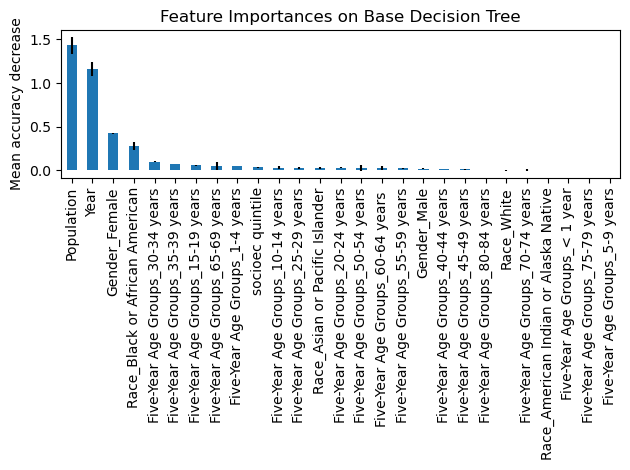

In [21]:
rate_features_permutation(dec_tree_reg, x_train, x_test, y_pred, model_name = dec_tree_name)

In [22]:
# TODO: evaluate data on 2021 data. So massage holdout_2021
def evaluate_on_2021():
    pass

In [ ]:
# visualize prediction vs actual: histplot and scatterplot (to visually inspect how model does)
# y_actual: array-like of actual predictions
def evaluate_model(y_pred, y_actual, model_name = 'default_model',  x_test = None):
    rmse = round(mean_squared_error(y_actual, y_pred, squared = False), 4)
    print(f"RMSE for {model_name} is {rmse}")
    
#     plt.figure(figsize=(16,4))
    if x_test is not None:
        print("Not None")
        # TODO: fix these graphs 1 row, 3 col visual
#         fig, axes = plt.subplots(1,3, figsize = (16,4))
#         axes[0].set_yscale('log') # set histplot on log scale to visualize - relatively bell-curved
#     #     axes[0].set_xscale('log')
#         sns.histplot(y_actual-y_pred, ax = axes[0])
#         plt.scatter(y_actual,y_pred, ax = axes[1])
#         p1 = max(max(y_pred), max(y_actual))
#         p2 = min(min(y_pred), min(y_actual))
#         plt.plot([p1, p2], [p1, p2], 'b-')
        
#         plt.scatter(x_test.values, y_test, color = 'red', ax = axes[2] )
#         plt.scatter(x_test.values, y_pred, color = 'green', ax = axes[2])
#         plt.show()
        
        # 1 row, 2 col visual
#         print("X_test is empty")
#         fig, axes = plt.subplots(1,2, figsize = (16,4))
#         axes[0].set_yscale('log') # set histplot on log scale to visualize - relatively bell-curved
#         axes[0].set_xscale('log')
        plt.yscale('log') # log b/c the majority of predictions = actual, so diff = 0 for majority

        plt.title(model_name + ': Distribution of Differences')
        sns.histplot(y_actual-y_pred)#, ax = axes[0])
        plt.show()
        
        
        fig, ax = plt.subplots()
        plt.title(model_name + ': Pred vs Actual')
        plt.scatter(y_actual,y_pred)
        ax.set_ylabel('Prediction (Crude Rate)')
        ax.set_xlabel('Actual (Crude Rate)')
        p1 = max(max(y_pred), max(y_actual))
        p2 = min(min(y_pred), min(y_actual))
        plt.plot([p1, p2], [p1, p2], 'r-') #b- for blue line instead
        
        plt.show()
        
        # export actuals and predictions for "smoothing" evaluations. Simple output and complete output (including features)
        y_output = pd.DataFrame({"actual": y_test['Crude Rate'], "predictions": y_pred})
        y_output.to_csv(f"Simple_{model_name}_ActualVSPred_RMSE_{rmse}.csv", index = False)
        
        y_output_full = x_test.join(y_actual).rename(columns = {'Crude Rate': 'Actual Crude Rate'})
        y_output_full['Predicted Crude Rate'] = y_pred #
        y_output_full.to_csv(f"Full_{model_name}_ActualVSPred_RMSE_{rmse}.csv", index = False)
        
    else: 
        # 1 row, 2 col visual
#         print("X_test is empty")
#         fig, axes = plt.subplots(1,2, figsize = (16,4))
#         axes[0].set_yscale('log') # set histplot on log scale to visualize - relatively bell-curved
#         axes[0].set_xscale('log')
        plt.yscale('log') # log b/c the majority of predictions = actual, so diff = 0 for majority

        plt.title(model_name + ': Distribution of Differences')
        sns.histplot(y_actual-y_pred)#, ax = axes[0])
        plt.show()
        
        
        fig, ax = plt.subplots()
        plt.title(model_name + ': Pred vs Actual')
        plt.scatter(y_actual,y_pred)
        ax.set_ylabel('Prediction (Crude Rate)')
        ax.set_xlabel('Actual (Crude Rate)')
        p1 = max(max(y_pred), max(y_actual))
        p2 = min(min(y_pred), min(y_actual))
        plt.plot([p1, p2], [p1, p2], 'r-') #b- for blue line instead
        
        plt.show()
        
        # export actuals and predictions for "smoothing" evaluations. Simple output and complete output (including features)
        y_output = pd.DataFrame({"actual": y_test['Crude Rate'], "predictions": y_pred})
        y_output.to_csv(f"Simple_{model_name}_ActualVSPred_RMSE_{rmse}.csv", index = False)
        


# evaluate_model(y_pred, y_test['Crude Rate'], x_test['Population'].values,"base decision tree model")
evaluate_model(y_pred, y_test['Crude Rate'],  model_name = dec_tree_name, x_test=x_test)


RMSE for Base Decision Tree is 4.0743
Not None


In [ ]:
# export the decision tree model to a tree_structure.dot file - paste the contents of the file to webgraphviz.com
# NOTE: too large to visualize appropriately, may need to do a smaller example
dot_data = export_graphviz(dec_tree_reg, out_file = None, 
               feature_names =x_train.columns, filled = True) #out_file ='tree_structure.dot'
graph = pydotplus.graphviz.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [ ]:
# visualize short tree as an example for pages
dec_tree_short_vis = DecisionTreeRegressor(random_state = seed, max_depth = 3)
dec_tree_short_vis.fit(x_train, y_train)
dot_data = export_graphviz(dec_tree_short_vis, out_file ='base_tree_structure_short.dot', 
               feature_names =x_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [ ]:
# hyperparameter tuning
# Reference: https://www.nbshare.io/notebook/312837011/Decision-Tree-Regression-With-Hyper-Parameter-Tuning-In-Python/
# Can also use ExtraTreesRegressor to be more selective in features, if we had more 
# parameters={"splitter":["best","random"],
#             "max_depth" : [1,3,5,7,9,11,12],
#            "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
#            "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
#            "max_features":["log2","sqrt",None],
#            "criterion": ['gini', 'entropy']
#            "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

parameters={ 
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "max_features":["log2","sqrt",None],
           "criterion": ['poisson', 'friedman_mse', 'squared_error'] }


# function for calculating how much time take for hyperparameter tuning

def timer(start_time=None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)
        print(thour,":",tmin,':',round(tsec,2))



In [ ]:

start_time = datetime.now()
tuning_dec_tree = GridSearchCV(dec_tree_reg,param_grid=parameters,scoring='neg_mean_squared_error',cv=3) #,verbose=3)

tuning_dec_tree.fit(x_train, y_train)

timer(start_time)

In [ ]:
# best hyperparameters
print(tuning_dec_tree.best_params_)
print(tuning_dec_tree.best_score_)
tuned_dec_tree_name = "Tuned Decision Tree"
# predict then evaluate prediction
y_pred = tuning_dec_tree.predict(x_test)
evaluate_model(y_pred, y_test['Crude Rate'],  model_name = tuned_dec_tree_name, x_test = x_test)
rate_features_permutation(dec_tree_reg, x_train, x_test, y_pred, model_name = tuned_dec_tree_name)


### Best Decision Tree (DT)

In [ ]:
# "best" decision tree from other set of parameters ends up with the below DT, with an RMSE of 7.7609....
# best_dt = DecisionTreeRegressor(random_state = seed, max_depth = 7, max_features = None,
#                                max_leaf_nodes = None, min_samples_leaf = 1,
#                                 min_weight_fraction_leaf = 0.1, splitter = 'best')
# best_dt.fit(x_train, y_train)
# best_dt_name = "Best Decision Tree"
# best_dt

In [ ]:
# predict then evaluate prediction
# y_pred = best_dt.predict(x_test)
# evaluate_model(y_pred, y_test['Crude Rate'],  model_name = best_dt_name)
# rate_features_permutation(dec_tree_reg, x_train, x_test, y_pred, model_name = best_dt_name)

In [ ]:
# export_graphviz(best_dt, out_file ='best_tree_structure.dot', 
#                feature_names =x_train.columns)
# graph = pydotplus.graph_from_dot_data(dot_data)
# Image(graph.create_png())

# Random Forest

In [ ]:
# random forest with 1000 decision trees
rf_base = RandomForestRegressor(n_estimators = 100, random_state = seed) #sklearn's RF

rf_base.fit(x_train, y_train['Crude Rate'])
rf_base_name = 'Random Forest Initial Model'
# use this model instead if you want to use "out-of-bag" samples to estimate R^2 on unseen data 
# generally, if > 0.75, model will generalize well
# rf_out_of_bag = RandomForestRegressor(n_estimators = 1000, random_state = seed, oob_score = True) 
# rf_out_of_bag.fit(x_train, y_train)
# print(rf_out_of_bag.oob_score_) 

In [ ]:
y_pred = rf_base.predict(x_test)
evaluate_model(y_pred, y_test['Crude Rate'], model_name = rf_base_name, x_test = x_test)
rate_features_permutation(rf_base, x_train, x_test, y_pred, model_name = rf_base_name)

In [ ]:
# Best random forest
# hyperparameter tuning
param_grid = { 
    'n_estimators': [50, 100, 200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [3,4,5,6,7,8],
    'criterion' :['friedman_mse', 'squared_error']
}


In [ ]:

random_forest_tuner = RandomForestRegressor(random_state = seed)

start_time = datetime.now()
random_forest_grid = GridSearchCV(estimator=random_forest_tuner, param_grid=param_grid, cv=5)
random_forest_grid.fit(x_train, y_train['Crude Rate'])
print('Time to find best random forest parameters: ') # takes around 20 minutes
timer(start_time)

In [ ]:
print(random_forest_grid.best_params_)
print(random_forest_grid.best_score_)
random_forest_grid

In [ ]:
best_rf = RandomForestRegressor(random_state = seed, criterion = 'friedman_mse', 
                                max_depth = 8, max_features = 'sqrt', n_estimators = 500)
best_rf

In [ ]:
best_rf.fit(x_train, y_train['Crude Rate'])

In [ ]:
best_rf.feature_importances_

In [ ]:
y_pred = rf_base.predict(x_test)
best_rf_name = 'Random Forest Best Model'
evaluate_model(y_pred, y_test['Crude Rate'], model_name = best_rf_name, x_test = x_test)
rate_features_permutation(best_rf, x_train, x_test, y_pred, model_name = best_rf_name)

# XGBoost

In [ ]:
x_train.columns = x_train.columns.str.replace('<','')
x_test.columns = x_test.columns.str.replace('<','')
x_train

In [ ]:
boost = XGBRegressor(random_state = seed)
boost.fit(x_train, y_train['Crude Rate'])
boost_base_name = 'XGBoost Base Model'
y_pred = boost.predict(x_test)
evaluate_model(y_pred, y_test['Crude Rate'], boost_base_name,  x_test = x_test)
rate_features_permutation(boost, x_train, x_test, y_pred, model_name = boost_base_name)

In [ ]:
# Best XGBoost model
# params = { 'max_depth': [3,6,10],
#            'learning_rate': [0.01, 0.05, 0.1],
#            'n_estimators': [100, 500, 1000],
#            'colsample_bytree': [0.3, 0.7]}

params_boost = { 'max_depth': [5, 10, 20], # [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.5],  #, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
#            'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}

In [ ]:
# estimated at 3 hours - 6 fits per second for 64800 fits... 
# in reality, was taking beyond 16 hours...
boost_best_mod = XGBRegressor(random_state = seed)
boost_base_name = 'XGBoost Best Model'
start_time = datetime.now()
best_boost = GridSearchCV(estimator=boost_best_mod, 
                   param_grid=params_boost,
                   scoring='neg_mean_squared_error')
#                    verbose=1)

best_boost.fit(x_train, y_train['Crude Rate'])
y_pred = best_boost.predict(x_test)
evaluate_model(y_pred, y_test['Crude Rate'], boost_base_name,  x_test = x_test)
rate_features_permutation(best_boost, x_train, x_test, y_pred, model_name = boost_base_name)
print('Time to find best XGBoost parameters: ') 
timer(start_time)

In [ ]:
# evaluate_model(y_pred, y_test['Crude Rate'], 'XGBoost Best Model')
# timer(start_time)
# boost_best_mod_2 = XGBRegressor(seed = seed)
# start_time = datetime.now()
# best_boost_2 = GridSearchCV(estimator=boost_best_mod_2, 
#                    param_grid=params_boost,
#                    scoring='neg_mean_squared_error')

# best_boost_2.fit(x_train, y_train['Crude Rate'])
# y_pred_2 = best_boost_2.predict(x_test)
# evaluate_model(y_pred_2, y_test['Crude Rate'], 'XGBoost Best Model').fit()
# timer(start_time)